In [1]:
import os
os.environ['XLA_PYTHON_CLIENT_PREALLOCATE']='false'

import jax

from jax import random, jit, vmap, grad
from jax import numpy as jnp
from jax.lax import cond

import astropy
import numpy as np
import healpy as hp

import h5py
import astropy.units as u

from astropy.cosmology import Planck15, FlatLambdaCDM, z_at_value
import astropy.constants as constants
from jax.scipy.special import logsumexp
from scipy.interpolate import interp1d
from scipy.stats import gaussian_kde
from tqdm import tqdm

import matplotlib
%matplotlib inline

import matplotlib.pyplot as plt
matplotlib.rcParams['font.family'] = 'Times New Roman'
matplotlib.rcParams['font.sans-serif'] = ['Bitstream Vera Sans']
matplotlib.rcParams['text.usetex'] = False
matplotlib.rcParams['mathtext.fontset'] = 'cm'
matplotlib.rcParams['figure.figsize'] = (16.0, 10.0)
matplotlib.rcParams['axes.unicode_minus'] = False

import seaborn as sns
sns.set_context('talk')
sns.set_style('ticks')
sns.set_palette('colorblind')
c=sns.color_palette('colorblind')

jax.config.update("jax_enable_x64", True)
jax.config.update('jax_default_matmul_precision', 'highest')


In [2]:
from jaxinterp2d import interp2d, CartesianGrid

H0Planck = Planck15.H0.value
Om0Planck = Planck15.Om0
speed_of_light = constants.c.to('km/s').value

zMax = 5.0
zgrid = jnp.expm1(np.linspace(np.log(1), np.log(zMax+1), 1000))
Om0grid = jnp.linspace(Om0Planck-0.1,Om0Planck+0.1,50)

rs = []
for Om0 in tqdm(Om0grid):
    cosmo = FlatLambdaCDM(H0=H0Planck,Om0=Om0)
    rs.append(cosmo.comoving_distance(zgrid).to(u.Mpc).value)

rs = jnp.asarray(rs)
rs = rs.reshape(len(Om0grid),len(zgrid))

@jit
def E(z,Om0=Om0Planck):
    return jnp.sqrt(Om0*(1+z)**3 + (1.0-Om0))

@jit
def r_of_z(z,H0,Om0=Om0Planck):
    return interp2d(Om0,z,Om0grid,zgrid,rs)*(H0Planck/H0)

@jit
def dL_of_z(z,H0,Om0=Om0Planck):
    return (1+z)*r_of_z(z,H0,Om0)

@jit
def z_of_dL(dL,H0,Om0=Om0Planck):
    return jnp.interp(dL,dL_of_z(zgrid,H0,Om0),zgrid)

@jit
def dV_of_z(z,H0,Om0=Om0Planck):
    return speed_of_light*r_of_z(z,H0,Om0)**2/(H0*E(z,Om0))

@jit
def ddL_of_z(z,dL,H0,Om0=Om0Planck):
    return dL/(1+z) + speed_of_light*(1+z)/(H0*E(z,Om0))

2025-02-09 21:29:47.026679: W external/xla/xla/service/gpu/nvptx_compiler.cc:930] The NVIDIA driver's CUDA version is 12.3 which is older than the PTX compiler version 12.6.77. Because the driver is older than the PTX compiler version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.
100%|██████████| 50/50 [00:00<00:00, 251.14it/s]


In [3]:
GWTC1=True

with h5py.File('../../darksirens/posterior_samples/GWTC-3_posterior_samples_m1detm2detdLradec_4096_1peryear.h5', 'r') as inp:
    if GWTC1:
        nsamps = inp.attrs['nsamp']
        nEvents = inp.attrs['nobs']
        ra = jnp.array(inp['ra'])
        dec = jnp.array(inp['dec'])
        m1det = jnp.array(inp['m1det'])
        m2det = jnp.array(inp['m2det'])
        dL = jnp.array((jnp.array(inp['dL'])*u.Mpc).value)
    else:
        nGWTC1 = 10
        nsamps = inp.attrs['nsamp']
        nEvents = inp.attrs['nobs'] - nGWTC1
        ra = jnp.array(inp['ra'])[int(nGWTC1*nsamps):]
        dec = jnp.array(inp['dec'])[int(nGWTC1*nsamps):]
        m1det = jnp.array(inp['m1det'])[int(nGWTC1*nsamps):]
        m2det = jnp.array(inp['m2det'])[int(nGWTC1*nsamps):]
        dL = jnp.array((jnp.array(inp['dL'])*u.Mpc).value)[int(nGWTC1*nsamps):]

nsamp = 4096
ra = ra.reshape(nEvents,nsamps)[:,0:nsamp]#.flatten()
dec = dec.reshape(nEvents,nsamps)[:,0:nsamp]#.flatten()
m1det = m1det.reshape(nEvents,nsamps)[:,0:nsamp]#.flatten()
m2det = m2det.reshape(nEvents,nsamps)[:,0:nsamp]#.flatten()
dL = dL.reshape(nEvents,nsamps)[:,0:nsamp]#.flatten()

ra = ra[0:nEvents].flatten()
dec = dec[0:nEvents].flatten()
m1det = m1det[0:nEvents].flatten()
m2det = m2det[0:nEvents].flatten()
dL = dL[0:nEvents].flatten()

p_pe = dL**2#*jnp.cos(dec)*jnp.ones_like(ra)/(4*jnp.pi)

print(nEvents,nsamp)
print(z_of_dL(dL,140,Om0grid[-1]).max())

69 4096
4.728023646248869


In [4]:
def extract_selection_samples(file, nsamp=None, desired_pop_wt=None, far_threshold=1, rng=None):
    """Return `(m1, q, z, pdraw, nsel)` to estimate selection effects.
    
    :param file: The injection file.

    :param nsamp: The number of samples to be returned.

    :param desired_pop_wt: Function giving a weight in `(m1, q, z)` from which
        the population of injections should be drawn.  If none is given, the
        reference distribution for the actual injections will be used; otherwise
        the distribution of injections will be re-weighted to achieve the
        desired poplation.

    :param far_threshold: The threshold on the FAR (per year) at which an
        injection is considered detected.

    :param rng: A random number generator for the draws; if `None`, one will be
        initialized randomly.

    :return: A tuple `(m1, q, z, pdraw, nsel)`, giving a draw of detected
        injections from the desired population.  `pdraw` is properly normalized
        for estimating detectability as in, e.g., [Farr
        (2019)](https://ui.adsabs.harvard.edu/abs/2019RNAAS...3...66F/abstract).
    """
    if rng is None:
        rng = np.random.default_rng()

    with h5py.File(file, 'r') as f:
        m1detsels = np.array(f['injections/mass1'][:])
        m2detsels = np.array(f['injections/mass2'][:])
        dLsels = np.array(f['injections/distance'][:])
        rasels = f['injections/right_ascension'][:]
        decsels = f['injections/declination'][:]
        zsels = z_of_dL(dLsels,H0Planck,Om0Planck)
        pdraw_sel = np.array(f['injections/mass1_source_mass2_source_sampling_pdf'])*np.array(f['injections/redshift_sampling_pdf'])/(1+zsels)**2/ddL_of_z(zsels,dLsels,H0Planck,Om0Planck)

        pycbc_far = np.array(f['injections/far_pycbc_hyperbank'])
        pycbc_bbh_far = np.array(f['injections/far_pycbc_bbh'])
        gstlal_far = np.array(f['injections/far_gstlal'])
        mbta_far = np.array(f['injections/far_mbta'])

        detected = (pycbc_far < far_threshold) | (pycbc_bbh_far < far_threshold) | (gstlal_far < far_threshold) | (mbta_far < far_threshold)

        ndraw = f.attrs['n_accepted'] + f.attrs['n_rejected']

        T = (f.attrs['end_time_s'] - f.attrs['start_time_s'])/(3600.0*24.0*365.25) 
        pdraw_sel /= T

        m1detsels = m1detsels[detected]
        m2detsels = m2detsels[detected]
        dLsels = dLsels[detected]
        pdraw_sel = pdraw_sel[detected]
        rasels = rasels[detected]
        decsels = decsels[detected]

        if desired_pop_wt is None:
            pop_wt = pdraw_sel
        else:
            pop_wt = desired_pop_wt(m1s_sel, qs_sel, zs_sel)

        unnorm_wt = pop_wt/pdraw_sel
        sum_norm_wt = unnorm_wt / np.sum(unnorm_wt)
        pdraw_wt = pop_wt / (np.sum(unnorm_wt) / ndraw)
        
#         if nsamp is None:
#             inds = rng.choice(len(m1s_sel), size=nsamp, p=sum_norm_wt)
#             m1s_sel_cut = m1s_sel[inds]
#             qs_sel_cut = qs_sel[inds]
#             zs_sel_cut = zs_sel[inds]
#             pdraw_sel_cut = pdraw_wt[inds]
#             ndraw_cut = nsamp

#             return m1s_sel_cut, qs_sel_cut, zs_sel_cut, pdraw_sel_cut, ndraw_cut
#         else:
        return m1detsels, m2detsels, dLsels, rasels, decsels, pdraw_wt, ndraw

injection_file = "../../darksirens/selection_samples/endo3_bbhpop-LIGO-T2100113-v12.hdf5"

m1detsels, m2detsels, dLsels, rasels, decsels, p_draw, Ndraw = extract_selection_samples(injection_file)

m1detsels = jnp.array(m1detsels)
m2detsels = jnp.array(m2detsels)


dLsels = jnp.array(dLsels)

rasels = jnp.array(rasels)
decsels = jnp.array(decsels)
p_draw = jnp.array(p_draw)

print(p_draw.shape, Ndraw, p_draw.sum())
print(z_of_dL(dLsels,140,Om0grid[-1]).max())


(78864,) 73957576 8.125357053768903
3.7173629229341483


In [5]:
@jit
def dV_of_z_normed(z,H0,Om0,gamma):
    dV = dV_of_z(zgrid,H0,Om0)*(1+zgrid)**(gamma-1)
    prob = dV/jnp.trapezoid(dV,zgrid)
    return jnp.interp(z,zgrid,prob)


In [6]:
from jax.scipy.stats import norm

mass = jnp.linspace(1, 250, 2000)
mass_ratio =  jnp.linspace(0, 1, 2000)

def Sfilter_low(m,m_min,dm_min):
    """
    Smoothed filter function

    See Eq. B5 in https://arxiv.org/pdf/2111.03634.pdf
    """
    def f(mm,deltaMM):
        return jnp.exp(deltaMM/mm + deltaMM/(mm-deltaMM))
    
    S_filter = 1./(f(m-m_min,dm_min) + 1.)
    S_filter = jnp.where(m<m_min+dm_min,S_filter,1.)
    S_filter = jnp.where(m>m_min,S_filter,0.)
    return S_filter

def Sfilter_high(m,m_max,dm_max):
    """
    Smoothed filter function

    See Eq. B5 in https://arxiv.org/pdf/2111.03634.pdf
    """
    def f(mm,deltaMM):
        return jnp.exp(deltaMM/mm + deltaMM/(mm-deltaMM))
    
    S_filter = 1./(f(m-m_max,-dm_max) + 1.)
    S_filter = jnp.where(m>m_max-dm_max,S_filter,1.)
    S_filter = jnp.where(m<m_max,S_filter,0.)
    return S_filter

@jit
def logpm1_powerlaw(m1,m_min,m_max,alpha,dm_min,dm_max):

    pm1 = Sfilter_low(mass,m_min,dm_min)*mass**(-alpha)*Sfilter_high(mass,m_max,dm_max)
    pm1 = pm1/jnp.trapezoid(pm1,mass)
    return jnp.log(jnp.interp(m1,mass,pm1))

@jit
def logpm1_peak(m1,mu,sigma):
    pm1 =  jnp.exp(-(mass - mu)**2 / (2 * sigma ** 2))
    pm1 = pm1/jnp.trapezoid(pm1,mass)
    return jnp.log(jnp.interp(m1,mass,pm1))

@jit
def logfq(m1,m2,beta):
    q = m2/m1
    pq = mass_ratio**beta
    pq = pq/jnp.trapezoid(pq,mass_ratio)

    log_pq = jnp.log(jnp.interp(q,mass_ratio,pq))

    return log_pq

In [7]:
@jit
def logpm1_powerlaw_powerlaw(m1,m_min_1,m_max_1,alpha_1,dm_min_1,dm_max_1,m_min_2,m_max_2,alpha_2,dm_min_2,dm_max_2,f1):
    p1 = jnp.exp(logpm1_powerlaw(m1,m_min_1,m_max_1,alpha_1,dm_min_1,dm_max_1))
    p2 = jnp.exp(logpm1_powerlaw(m1,m_min_2,m_max_2,alpha_2,dm_min_2,dm_max_2))

    pm1 = f1*p1 + (1-f1)*p2 
    return jnp.log(pm1)


@jit
def log_p_pop_powerlaw_powerlaw(m1,m2,m_min_1,m_max_1,alpha_1,dm_min_1,dm_max_1,m_min_2,m_max_2,alpha_2,dm_min_2,dm_max_2,beta,f1):
    log_dNdm1 = logpm1_powerlaw_powerlaw(m1,m_min_1,m_max_1,alpha_1,dm_min_1,dm_max_1,m_min_2,m_max_2,alpha_2,dm_min_2,dm_max_2,f1)
    log_dNdm2 = logpm1_powerlaw_powerlaw(m2,m_min_1,m_max_1,alpha_1,dm_min_1,dm_max_1,m_min_2,m_max_2,alpha_2,dm_min_2,dm_max_2,f1)
    log_fq = logfq(m1,m2,beta)

    log_p_sz = np.log(0.25) # 1/2 for each spin dimension

    return log_p_sz + log_dNdm1 + log_dNdm2 + log_fq 

In [8]:
@jit
def logdiffexp(x, y):
    return x + jnp.log1p(jnp.exp(y-x))

In [9]:
H0 = H0Planck
Om0 = Om0Planck

@jit
def likelihood(gamma,m_min_1,m_max_1,alpha_1,dm_min_1,dm_max_1,m_min_2,m_max_2,alpha_2,dm_min_2,dm_max_2,beta,f1):

    zsels = z_of_dL(dLsels, H0, Om0)
    m1sels = m1detsels/(1+zsels)
    m2sels = m2detsels/(1+zsels)

    log_det_weights = log_p_pop_powerlaw_powerlaw(m1sels,m2sels,m_min_1,m_max_1,alpha_1,dm_min_1,dm_max_1,m_min_2,m_max_2,alpha_2,dm_min_2,dm_max_2,beta,f1)

    log_det_weights += - jnp.log(ddL_of_z(zsels,dLsels,H0,Om0)) - jnp.log(p_draw) - 2*jnp.log1p(zsels) + jnp.log(dV_of_z_normed(zsels,H0,Om0,gamma))

    log_mu = logsumexp(log_det_weights) - jnp.log(Ndraw)
    log_s2 = logsumexp(2*log_det_weights) - 2.0*jnp.log(Ndraw)
    log_sigma2 = logdiffexp(log_s2, 2.0*log_mu - jnp.log(Ndraw))
    Neff = jnp.exp(2.0*log_mu - log_sigma2)

    ll = -jnp.inf
    ll = jnp.where((Neff <= 10 * nEvents), ll, 0)
    ll += -nEvents*log_mu + nEvents*(3 + nEvents)/(2*Neff)

    z = z_of_dL(dL, H0, Om0)
    m1 = m1det/(1+z)
    m2 = m2det/(1+z)

    log_weights = log_p_pop_powerlaw_powerlaw(m1,m2,m_min_1,m_max_1,alpha_1,dm_min_1,dm_max_1,m_min_2,m_max_2,alpha_2,dm_min_2,dm_max_2,beta,f1)

    log_weights += - jnp.log(ddL_of_z(z,dL,H0,Om0)) - jnp.log(p_pe) - 2*jnp.log1p(z) + jnp.log(dV_of_z_normed(z,H0,Om0,gamma))

    log_weights = log_weights.reshape((nEvents,nsamp))
    ll += jnp.sum(-jnp.log(nsamp) + logsumexp(log_weights,axis=-1))
    
    return ll, Neff


In [10]:
theta = (#H0Planck, Om0Planck,
         0,3,70,2.4,0,0,3,70,2.4,0,0,3,0.2)
print(likelihood(*theta))

def loglike(coord):
    gamma,m_min_1,m_max_1,alpha_1,dm_min_1,dm_max_1,m_min_2,m_max_2,alpha_2,dm_min_2,dm_max_2,beta,f1 = coord
    if (1-f1<0):
        #print("potato mixture")
        return -np.inf
    ll, Neff = likelihood(gamma,m_min_1,m_max_1,alpha_1,dm_min_1,dm_max_1,m_min_2,m_max_2,alpha_2,dm_min_2,dm_max_2,beta,f1)
    if np.isnan(ll):
        return -np.inf
    else:
        return ll

(Array(-1572.75483895, dtype=float64), Array(20903.91404914, dtype=float64))


In [11]:
H0_lo = 20
H0_hi = 140

Om0_lo = Om0grid[0]
Om0_hi = Om0grid[-1]

gamma_low = 0
gamma_high = 10

m_min_1_low = 2
m_min_1_high = 10

m_max_1_low = 40
m_max_1_high = 100

alpha_1_low = 0
alpha_1_high = 6

dm_min_1_low = 1
dm_min_1_high = 100

dm_max_1_low = 1
dm_max_1_high = 100

m_min_2_low = 6
m_min_2_high = 50

m_max_2_low = 40
m_max_2_high = 100

alpha_2_low = 0
alpha_2_high = 6

dm_min_2_low = 1
dm_min_2_high = 100

dm_max_2_low = 1
dm_max_2_high = 100

beta_low = 0
beta_high = 6

mu_low = 45
mu_high = 90

sigma_low = 1
sigma_high = 10

f1_low = 0
f1_high = 1

f2_low = 0
f2_high = 1


lower_bound = np.array([#H0_lo,Om0_lo,
    gamma_low,m_min_1_low,m_max_1_low,alpha_1_low,dm_min_1_low,dm_max_1_low,m_min_2_low,m_max_2_low,alpha_2_low,dm_min_2_low,dm_max_2_low,beta_low,f1_low])
upper_bound = np.array([#H0_hi,Om0_hi,
    gamma_high,m_min_1_high,m_max_1_high,alpha_1_high,dm_min_1_high,dm_max_1_high,m_min_2_high,m_max_2_high,alpha_2_high,dm_min_2_high,dm_max_2_high,beta_high,f1_high])


ndims = len(lower_bound)
nlive = 1000

labels = [#'H0','Om0',
    'gamma','m_min_1','m_max_1','alpha_1','dm_m_min_1','dm_m_max_1','m_min_2','m_max_2','alpha_2','dm_m_min_2','dm_m_max_2','beta','f1']

    

def prior_transform(theta):
    transformed_params = [
        theta[i] * (upper_bound[i] - lower_bound[i]) + lower_bound[i] 
        for i in range(len(theta))
    ]
    
    return tuple(transformed_params)

In [12]:
from dynesty.utils import resample_equal
from dynesty import NestedSampler, DynamicNestedSampler
import multiprocessing as multi

bound = 'multi'
sample = 'rwalk'
nprocesses = 1
Dynamic = True

if Dynamic is True:
    dsampler = DynamicNestedSampler(loglike, prior_transform, ndims, bound=bound, sample=sample, nlive=nlive)#, pool=pool)
    dsampler.run_nested(n_effective=50000)
else:
    dsampler = NestedSampler(loglike, prior_transform, ndims, bound=bound, sample=sample, nlive=nlive)#, pool=pool)
    dsampler.run_nested(dlogz=0.1)

67810it [1:02:14, 18.16it/s, batch: 9 | bound: 42 | nc: 1 | ncall: 2100033 | eff(%):  3.181 | loglstar: -1512.896 < -1501.460 < -1503.846 | logz: -1518.976 +/-  0.062 | stop:  0.975]    


In [13]:
import corner

dres = dsampler.results

dlogZdynesty = dres.logz[-1]        # value of logZ
dlogZerrdynesty = dres.logzerr[-1]  # estimate of the statistcal uncertainty on logZ

# output marginal likelihood
print('Marginalised evidence (using dynamic sampler) is {} ± {}'.format(dlogZdynesty, dlogZerrdynesty))

# get the posterior samples
dweights = np.exp(dres['logwt'] - dres['logz'][-1])
dpostsamples = resample_equal(dres.samples, dweights)

print('Number of posterior samples (using dynamic sampler) is {}'.format(dpostsamples.shape[0]))

import pickle

# open a file, where you ant to store the data
file = open('PLPL', 'wb')

# dump information to that file
pickle.dump(dres, file)

# close the file
file.close()


Marginalised evidence (using dynamic sampler) is -1518.9471207215815 ± 0.05905599152618848
Number of posterior samples (using dynamic sampler) is 67810


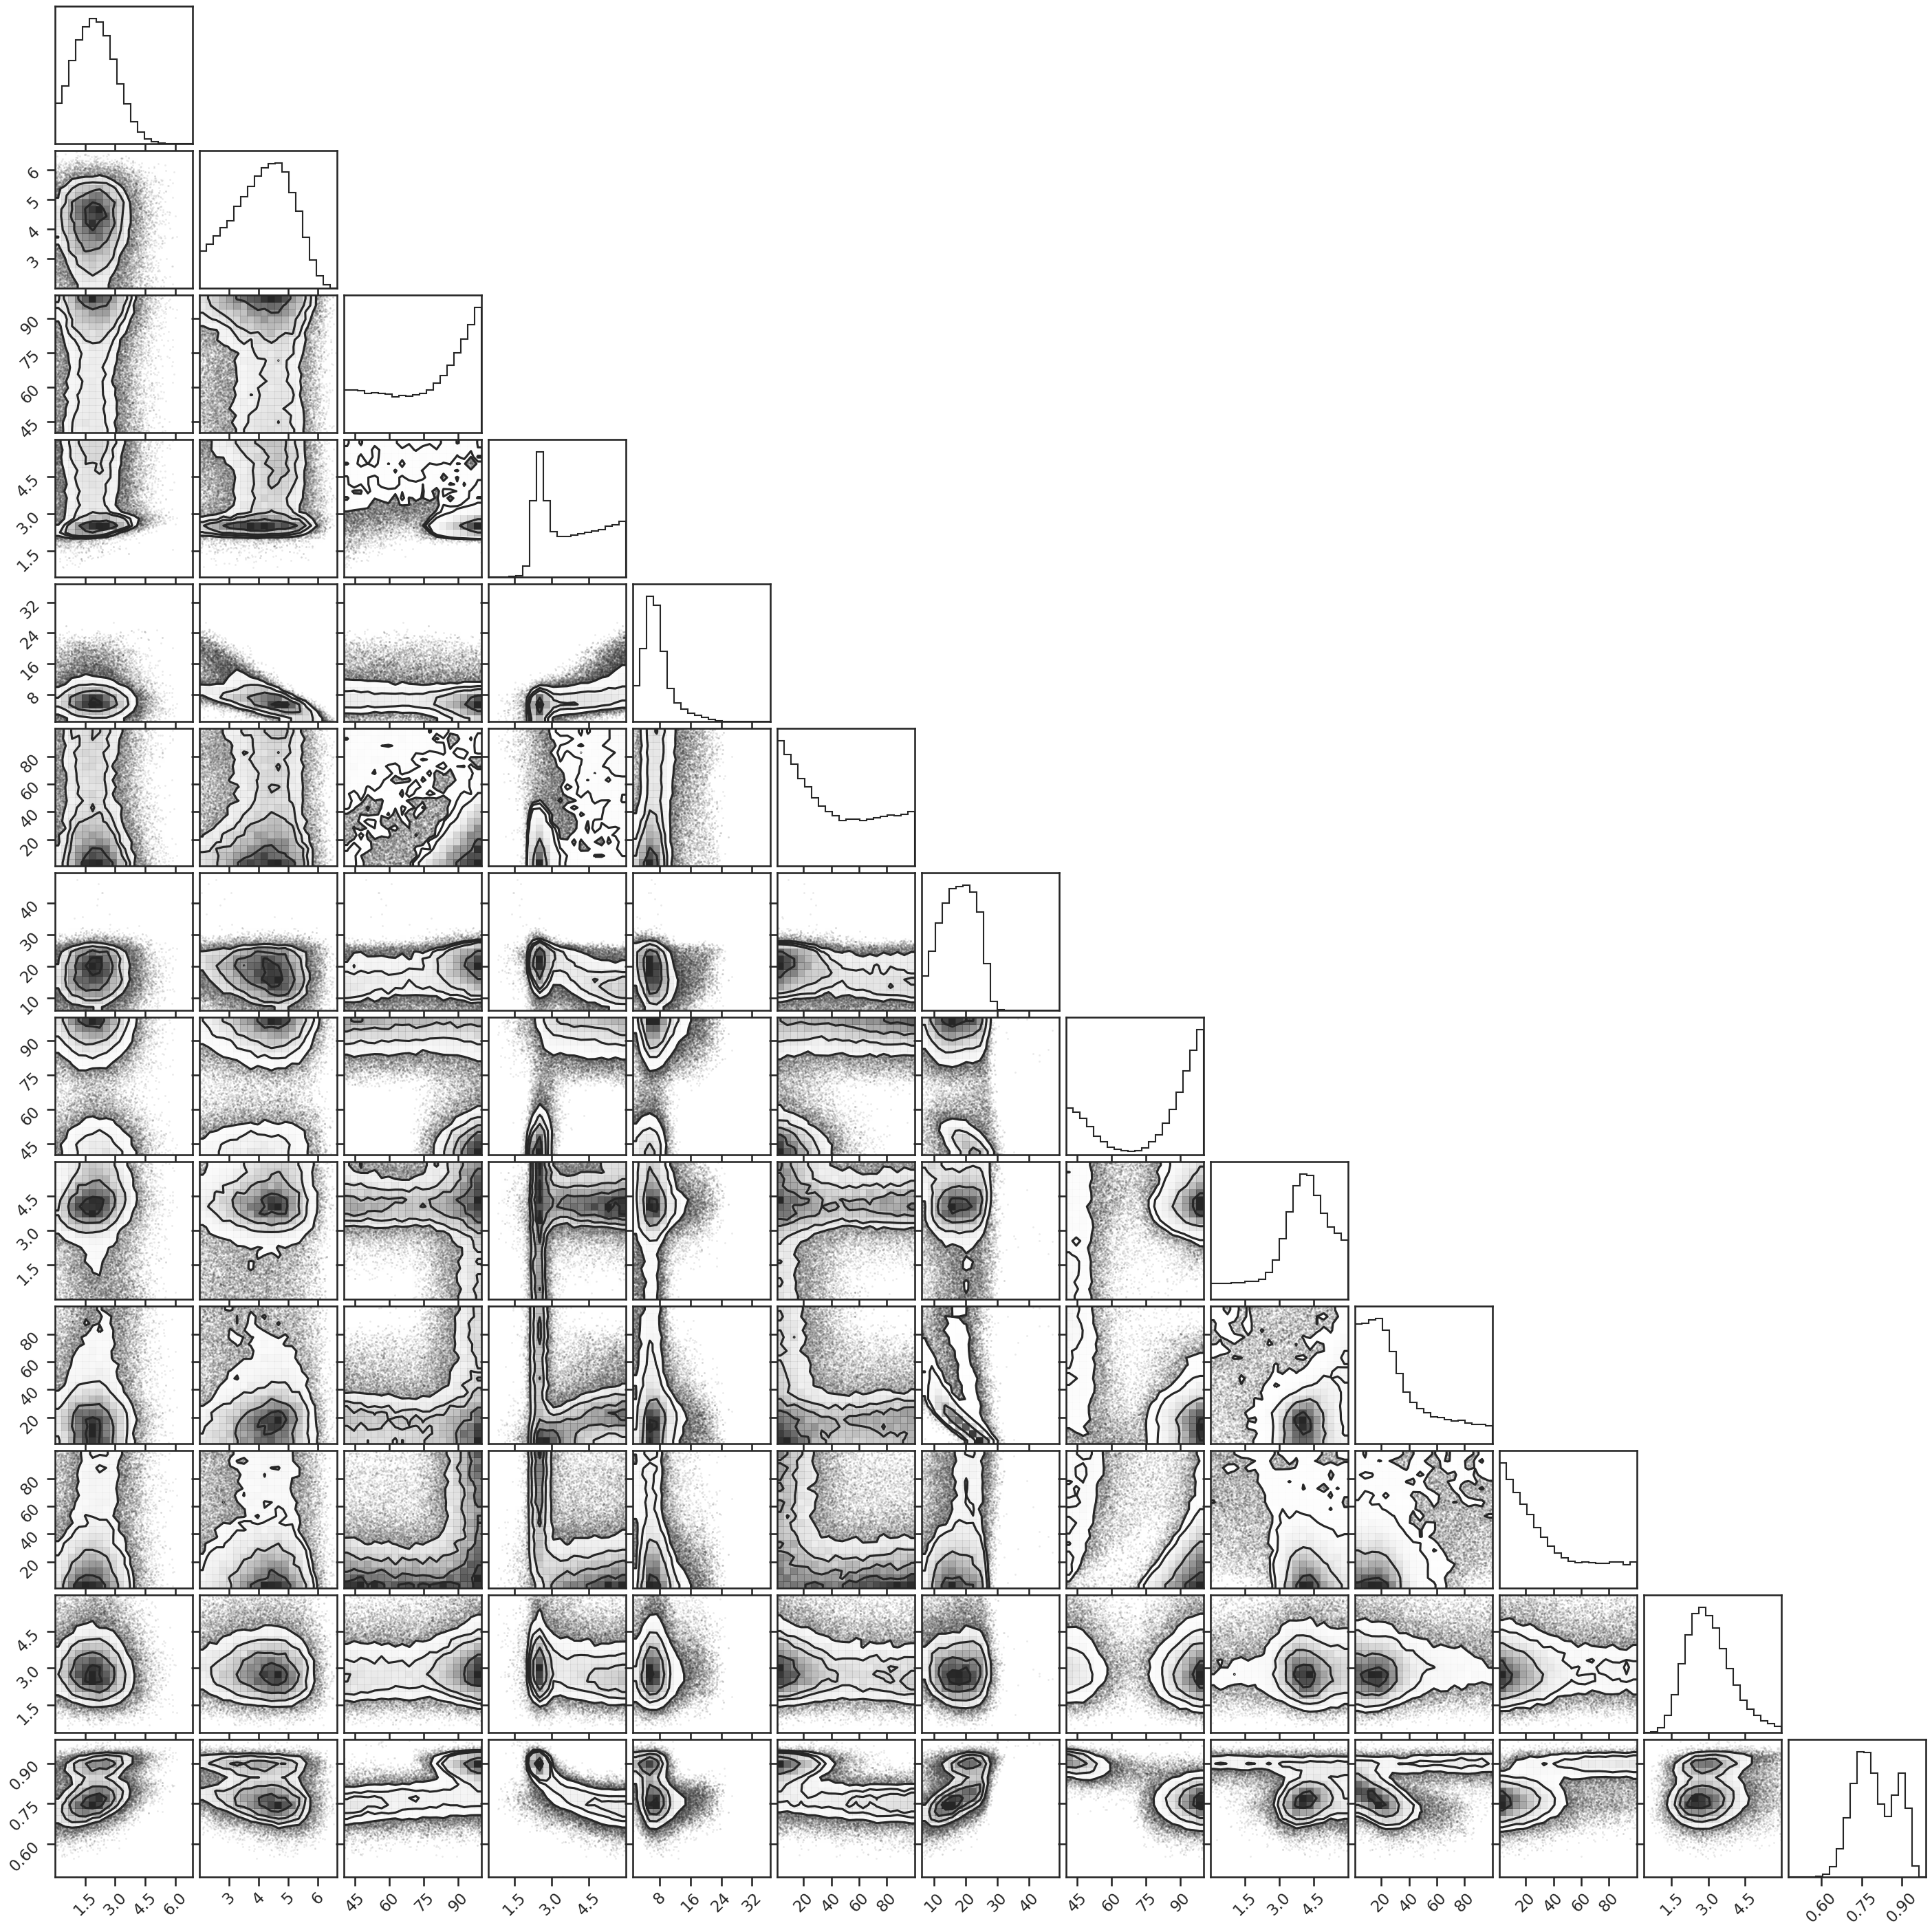

In [14]:
fig = corner.corner(dpostsamples,  hist_kwargs={'density': True})
plt.show()